# Đối với bào toán có dữ liệu liên tục - dùng đến model của Regression
- trong bài này có xử lý dữ liệu dạng số bị thiếu , biến đối nó
- xử lý dữ liệu dạng văn bản - xử lý dữ liệu bị thiếu , ...

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
!pip install lazypredict # cài thư viện lazy predict
!pip install ydata-profiling


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 63.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=8ae9573c67d5bcbcaa867fbfdcb1d8d7defce5adb292a0dbe51595b99c42097c
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [6]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport # in ra thông số vào 1 file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # thư viện giúp chúng ta điền vào những ô bị khuyết
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from lazypredict.Supervised import LazyRegressor # chọn loại bài toán là classification or regression

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
# Hiển thị tất cả các hàng và tất cả các cột
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Nếu bạn muốn hiển thị chiều rộng không giới hạn
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [8]:
# ô nào có data là some high school thì đổi thành high school
# ô nào khác vẫn là chính nó
def convert_level(level):
  if(level == "some high school"):
    level = "high school"
  return level

In [9]:
data  = pd.read_csv("/content/gdrive/MyDrive/1_Data_Science_Machine_Learning/TaiLieu/datasets/StudentScore.xls")

In [10]:
# tạo file cho phép xem dữ liệu
profile = ProfileReport(data, title="Score Report ", explorative=True)
profile.to_file("/content/gdrive/MyDrive/1_Data_Science_Machine_Learning/DAY7_Build_model_regression/png/score.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# print(data.head())
# print(data.shape)
# print(data.info())
# print(data.describe())


# Chọn các cột số để xem hệ số tương quan của chúng
# bài nào dữ liệu nguyên số chỉ cần gọi hàm corr còn k thì buộc phải làm v
df_numeric = data[['math score', 'reading score', 'writing score']]
print(df_numeric.corr())


               math score  reading score  writing score
math score           1.00           0.82           0.80
reading score        0.82           1.00           0.95
writing score        0.80           0.95           1.00


["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school']


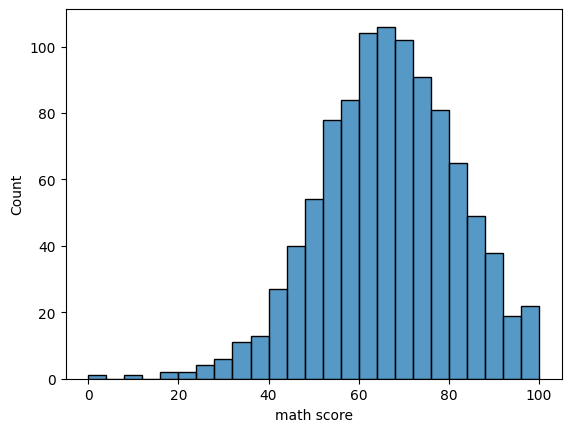

In [ ]:
sn.histplot(data["math score"]) # chọn 1 trong các cột số để làm target
# plt.title("Math score distribution")
# plt.savefig("/content/gdrive/MyDrive/1_Data_Science_Machine_Learning/DAY7_Build_model_regression/png/MathDistribution.png")

target = "math score"

x = data.drop(target, axis =1) # phải chú ý k ghi gì nó sẽ lấy theo hàng và lỗi , bạn phải chỉnh lại để nó lấy theo cột
# tạo một bản sao của DataFrame data nhưng bỏ đi cột có tên target.

# cập nhật lại dữ liệu 1 cột mà bạn muốn
x["parental level of education"] = x["parental level of education"].apply(convert_level)

print(x["parental level of education"].unique())

y = data[target]  # tạo 1 dataframe nhưng chỉ có 1 cột toán

In [ ]:
#split data
x_train , x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, random_state=42)

In [ ]:
print(x["gender"].unique()) # bạn nên kiểm tra những cột như giới tính (có thể có nhiều hơn ngoài nam và nữ)

['female' 'male']


In [ ]:
print(x["race/ethnicity"].unique())

['group B' 'group C' 'group A' 'group D' 'group E']


# Đối với dữ liệu dạng chữ
  - norminal feature dùng khi dữ liệu k có sự phân cấp
  - ordinal feature dùng khi dữ liệu có sự phân cấp
  - boolean - dành cho loại nào có 2 giá trị

# dữ liệu dạng số
  - minmaxScaler
  - standardScaler
  - robustScaler

In [ ]:
# dùng đến pipeline và dùng các tiền xử lý để xử lý data


# điền vào những ô số bị khuyết - mean or medium
# nhét hết các label vào 1 chỗ cho dễ
num_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="median")), # mean or medium
    ("scaler", StandardScaler())
    # dòng 1 là dòng điền dữ liệu trống
    # dòng 2 là tham số - để tiền xử lý dữ liệu
])


# print(x["parental level of education"].unique())
education_values = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
# dữ liệu lấy ra từ cột parental level of education và bạn phải sắp xếp nó theo thứ tự cấp bậc

# xử lý các cột boolean
gender_values = ["male", "female"] # chỉ có 2 đối tượng , thứ tự k quan trọng
lunch_values = x_train["lunch"].unique()
test_values = x_train["test preparation course"].unique()


# dùng ordinal để lấp đầy dữ liệu có phân cấp
# đối với ordinal dùng ordinalEncoder
ord_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
     # nếu dùng constant thì cần fill_value  , bạn có thể thay constant bằng most_frequent và k cần fill_value
    ("encoder", OrdinalEncoder(categories=[education_values, gender_values, lunch_values, test_values]))
])

# result = ord_transformer.fit_transform(x_train[["parental level of education"]])
# for i, j in zip(x["parental level of education"], result):
#   print("Before {}  After  {}".format(i,j))


# dùng nominal để lấp đầy dữ liệu k phân cấp
nom_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),  # có thể dùng chung dòng này cho cả ordinal và nominal vì đều là dữ liệu dạng categories
    ("encoder", OneHotEncoder(sparse_output=False))  # tắt tham số sparse thì dễ nhìn hơn
])

# result = nom_transformer.fit_transform(x_train[["reading score"]])
# for i, j in zip(x["reading score"], result):
#   print("Before {}  After  {}".format(i,j))

In [ ]:
# chỉ thẳng đầu xem cột nào dùng tiền xử lý nào

preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["reading score", "writing score"]),
    ("ordinal_features", ord_transformer, ["parental level of education", "gender","lunch", "test preparation course" ]),
    ("nominal_features", nom_transformer, ["race/ethnicity"]),
])



# với dữ liệu dạng boolean bạn có thể dùng cả ordinal và nominal - nhưng nếu chỉ có 2 phần tử bạn có thể ưu tiên ordinal (từ 3 phần tử chở lên mới được coi là thứ tự)
# cũng do dùng ordinalEncoder chỉ tạo ra 1 cột còn OneHotEncoding là 2 cột nên chọn ordinal sẽ tốn ít bộ nhớ hơn

In [ ]:
# thay lần lượt thành các model khác nhau để xem cái nào tốt hơn
reg = Pipeline(steps=[
    ("preprocessor", preprocessor), # chỉ định tiền xử lý
    ("regressor",  RandomForestRegressor()) #LinearRegression()) #SVR()) # ("regressor", RandomForestRegression()) - chỉ định model
])

# # lấy parameter của bài trước + tinh chỉnh lại
parameters = { # phải thêm thên label + __ để nó biết tham số của label nào
    "regressor__n_estimators": [50, 100, 200],
    "regressor__criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "regressor__max_depth" : [None, 5, 10, 20],
    "regressor__max_features" : ["sqrt", "log2"],
    "preprocessor__num_features__imputer__strategy": ["mean", "median"],  # cứ truyền vào cho đến khi gặp tham số cuối mới thôi
    "preprocessor__ordinal_features__imputer__strategy": ["most_frequent", "constant"],
    "preprocessor__ordinal_features__imputer__fill_value": [None, "unknown"],
    "preprocessor__nominal_features__imputer__strategy": ["most_frequent", "constant"],
    "preprocessor__nominal_features__imputer__fill_value": [None, "unknown"],
}
# tìm đúng dạng bài toán để xem tham số trên trang sklearn

# classification mặc định là accuracy
# regression mặc định là r2 bạn có thể đỏi sang neg_mean_absolute_error , neg_mean_squared_error , ..
#model = GridSearchCV(reg, param_grid=parameters, scoring= "r2", cv=6, verbose = 1, n_jobs =2)

# khi có quá nhiều tham số bạn hãy thử RandomizedSearchCV để nó chạy nhanh hơn
# tham số của nó sẽ hơi khác 1 tí
model = RandomizedSearchCV(reg, param_distributions=parameters, scoring= "r2", cv=6, verbose = 1, n_jobs =2, n_iter=20)
model.fit(x_train, y_train)
print(model.best_score_)
print(model.best_params_) # đưa ra tham số tốt nhất cho model
y_predict = model.predict(x_test)



# đặc tính của RandomizedSearchCv và GridSearch
# GridSearch sẽ thử hết các trường hơpk
# RandomizedSearchCV sẽ chỉ thử ngẫu nhiên n_iter trường hợp mà bạn đưa ra
# nếu được bạn vẫn nên dùng GridSearch nếu bạn có thời gian để có thể test full tham số


Fitting 6 folds for each of 20 candidates, totalling 120 fits
0.8293448006768339
{'regressor__n_estimators': 200, 'regressor__max_features': 'log2', 'regressor__max_depth': 10, 'regressor__criterion': 'friedman_mse', 'preprocessor__ordinal_features__imputer__strategy': 'most_frequent', 'preprocessor__ordinal_features__imputer__fill_value': 'unknown', 'preprocessor__num_features__imputer__strategy': 'mean', 'preprocessor__nominal_features__imputer__strategy': 'constant', 'preprocessor__nominal_features__imputer__fill_value': None}


In [ ]:
# các tham số
print("MAE {}".format(mean_absolute_error(y_test, y_predict))) # label trước - predict sau
print("MSE {}".format(mean_squared_error(y_test, y_predict)))
print("R2 {}".format(r2_score(y_test, y_predict)))


# Trong bài toán hồi quy, các tham số MAE, MSE và R² được dùng để đánh giá hiệu quả của mô hình dự đoán:

# MAE (Mean Absolute Error):
# Ý nghĩa: Đo trung bình sai số tuyệt đối giữa giá trị dự đoán và giá trị thực tế.
# Tác dụng: Cho biết trung bình mỗi dự đoán sai lệch bao nhiêu so với giá trị thực, với giá trị càng nhỏ thì mô hình càng chính xác.


# MSE (Mean Squared Error):
# Ý nghĩa: Tính trung bình bình phương các sai số giữa giá trị dự đoán và giá trị thực tế.
# Tác dụng: Phạt nặng hơn những dự đoán có sai số lớn do việc bình phương sai số. Giá trị MSE nhỏ cho thấy mô hình có dự đoán khá gần với giá trị thực.


# R² (R Squared hoặc Coefficient of Determination):
# Ý nghĩa: Đo lường tỷ lệ biến thiên của dữ liệu thực tế được mô hình giải thích.
# Tác dụng: Giá trị R² càng gần 1 cho thấy mô hình càng tốt vì nó giải thích được phần lớn biến thiên của dữ liệu. Nếu R² = 0, mô hình không giải thích được biến thiên nào, và giá trị âm nghĩa là mô hình dự đoán còn kém hơn so với việc sử dụng trung bình của dữ liệu.

MAE 4.923329382138853
MSE 40.83809625598823
R2 0.8321757015909194


# Test nhiều model cùng 1 lúc với LazyPredict
- nếu các model có hiệu năng gần ngang nhau - bạn phải xét đến thời gian thực hiện của nó - ngta có thể bỏ qua 1 chút về hiệu năng để lấy thời gian
- model sẽ đc sắp xếp từ trên xuống - hiệu năng giảm dần (cái nào tốt nhất ở trên đầu)
- nếu bạn k làm gì thì lazypredict nó sẽ tự dùng tiền xử lý của nó để xử dụng tiền xử lý của bạn
    x_train = reg.fit_transform(x_train) - reg là tên trong bài thôi
    x_test = reg.transform(x_test)


- nó luôn chỉ chạy các parameter mặc định của model - nếu bạn tìm được bộ tham số tốt hơn thì chưa chắc model nào tốt hơn đâu ????????

In [ ]:
# - nếu bạn k làm gì thì lazypredict nó sẽ tự dùng tiền xử lý của nó để xử dụng tiền xử lý của bạn
reg = Pipeline(steps=[
    ("preprocessor", preprocessor), # chỉ định tiền xử lý
])


x_train = reg.fit_transform(x_train)
x_test = reg.transform(x_test)

reg_lazy = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
model, predictions = reg_lazy.fit(x_train, x_test, y_train, y_test)
print(predictions)


100%|██████████| 42/42 [00:07<00:00,  5.44it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score 66.496250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -